In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from SACLA_XRD_functions import *
# import tifffile as tif
# %matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# From here should be the same
# fpd1_map = np.load('fpd1_map.npy')
fpd1_map = np.ones((1548, 2064))

# fpd1_mask = np.load('fpd1_mask.npy')
fpd1_mask = np.load('run_1620771_mask.npy')

fpd1_PONI = pyFAI.load('run_1620787_7.065keV.poni')
# fpd1_PONI = pyFAI.load('fpd1_r35.poni')  # Put new poni files in here

In [3]:
# Number of scattering angle bins
npt_rad = 2000
# Number of azimuthal angle bins
npt_azim = 360
# Range for the integration in 2 theta or A^-1
radial_range = [1.5, 5]  # I suggest [0, 90] or [0,15] when changing units
# Range for the integration in azimuth
azim_range = [15, 160]
# Units of the integration    Either "2th_deg" or "q_A^-1"  You need to change the radial rangne values as well as the string below
units="q_A^-1"

In [11]:
processed_runs = {} # Run this cell once to set up cache.

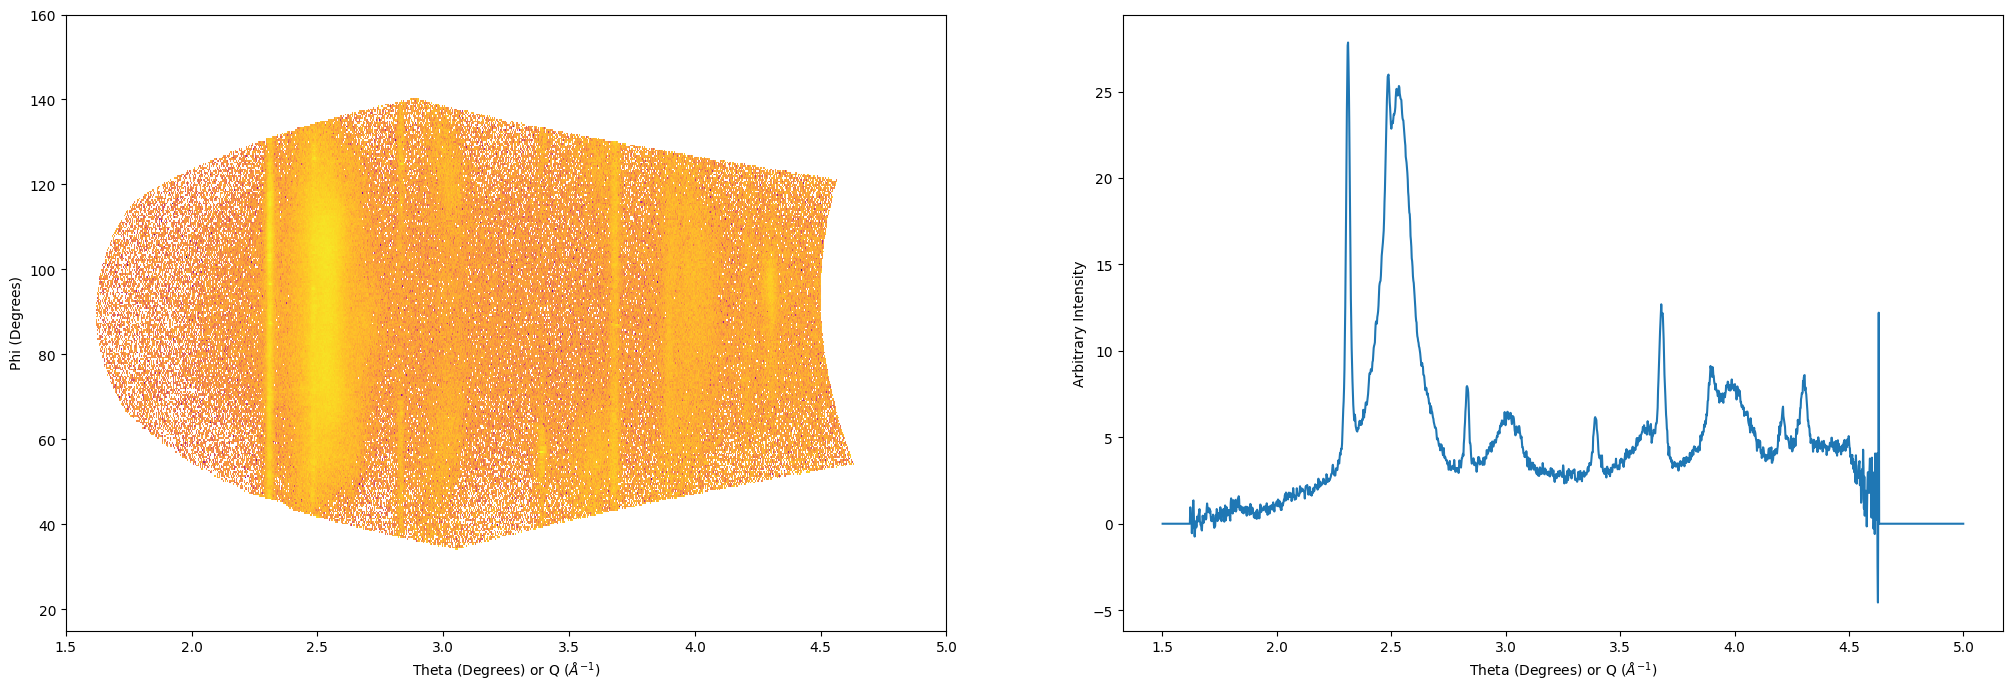

In [23]:
run_numbers = [1621257, 1621259]
# Put the runs you consider to be good below, also include them above.
good_runs = [1621257]
ims_fpd1 = False
fpd1_INTs = False
export = True
offset = 20
new_runs = {}
plot_all = False
plot_good = True
for idx, run_number in enumerate(run_numbers):
    try:
        fpd1_CAKE, fpd1_INT = processed_runs[run_number]['CAKE'], processed_runs[run_number]['INT']
    except:
        im_fpd1 = get_XRD_image(run_number, plot=False)
    
        if isinstance(ims_fpd1, bool):
            ims_fpd1 = im_fpd1
        else:
            ims_fpd1 = np.dstack((ims_fpd1, im_fpd1))
    
        # pyFAI integration for VAREX 1
        fpd1_CAKE = fpd1_PONI.integrate2d_ng(im_fpd1 * fpd1_map, npt_rad, npt_azim, azimuth_range=azim_range, radial_range=radial_range, correctSolidAngle=True, polarization_factor=1, unit=units, mask=fpd1_mask)
        fpd1_INT = fpd1_PONI.integrate1d_ng(im_fpd1 * fpd1_map, npt_rad, azimuth_range=azim_range, radial_range=radial_range, correctSolidAngle=True, polarization_factor=1, unit=units, mask=fpd1_mask)

        processed_runs[run_number] = {}
        processed_runs[run_number]['CAKE'] = fpd1_CAKE
        processed_runs[run_number]['INT'] = fpd1_INT
        new_runs[run_number] = processed_runs[run_number]
    
    if plot_all:
        plot(fpd1_CAKE, fpd1_INT, run_number=run_number)
    elif plot_good:
        if run_number in good_runs:
            plot(fpd1_CAKE, fpd1_INT, run_number=run_number)
        elif run_number in new_runs:
            plot(fpd1_CAKE, fpd1_INT, run_number=run_number)
    else:
        if run_number in new_runs:
            plot(fpd1_CAKE, fpd1_INT, run_number=run_number)

    if isinstance(fpd1_INTs, bool):
        fpd1_INTs = fpd1_INT.intensity + (idx*offset)
    else:
        fpd1_INTs = np.vstack((fpd1_INTs, fpd1_INT.intensity + (idx*offset)))

    if export:
        lineout_exportrun = np.stack((fpd1_INT.radial, fpd1_INT.intensity),axis=1)
        np.savetxt(f'xys/{run_number}.xy',lineout_exportrun)

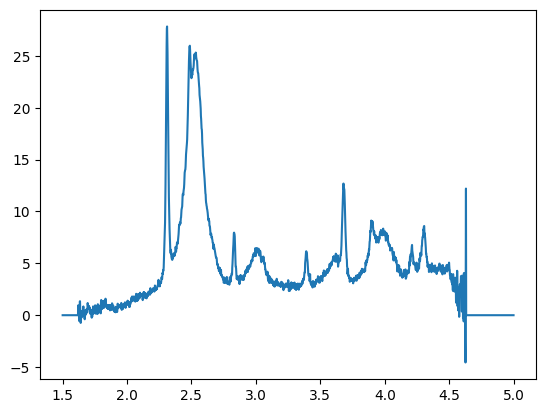

In [24]:
count=0
offset=20
for run_number in good_runs:
    plt.plot(processed_runs[run_number]['INT'].radial, processed_runs[run_number]['INT'].intensity+count*offset)
    count+=1
for run_number in new_runs:
    plt.plot(processed_runs[run_number]['INT'].radial, processed_runs[run_number]['INT'].intensity+count*offset)
    count+=1

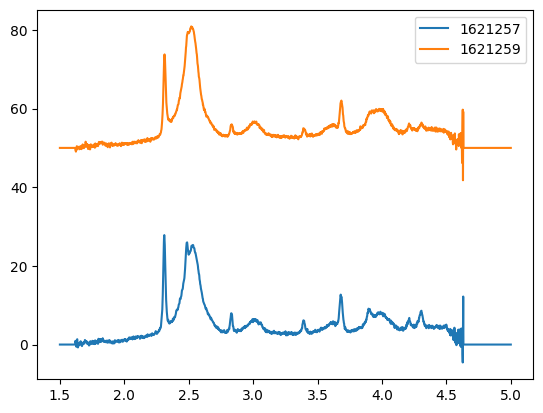

In [25]:
plt.plot(fpd1_INT.radial, np.transpose(fpd1_INTs), label=run_numbers)
plt.legend()